In [1]:
#Qiskit Machine Learning
#A set of tools, algorithms and software for use with IBM QCs to investigate 
#how to use quantum computing to solve machine learning problems.

#Qiskit Aqua: qGAN for Loading Random Distributions
#We have a k-dimensional data sample
#We employ a quantum Generative Adversarial Network (qGAN) 
#to learn the underlying random distribution and 
#to load it into a quantum state:

import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import time
start = time.time()
from qiskit import QuantumRegister, QuantumCircuit
from qiskit.aqua.components.optimizers import ADAM
from qiskit.aqua.components.uncertainty_models import UniformDistribution, UnivariateVariationalDistribution, MultivariateVariationalDistribution 
from qiskit.aqua.components.variational_forms import RY

from qiskit.aqua.algorithms.adaptive import QGAN
from qiskit.aqua.components.neural_networks.quantum_generator import QuantumGenerator
from qiskit.aqua.components.neural_networks.numpy_discriminator import NumpyDiscriminator

from qiskit.aqua import aqua_globals, QuantumInstance
from qiskit.aqua.components.initial_states import Custom

from qiskit import BasicAer
import pandas as pd
#from torch import optim

In [2]:
#To access IBMQ devices, we need an API token. 
#MY_API_TOKEN='eb1f119872f7e77a399da8a5384ecf5fd4a80d5b7aabd15f536e4c4b839ff5f61dd75a262cd02634eeb6e797b87987dae559e301aa8156bf502d3c82a8ea48bc'
from qiskit import IBMQ
from qiskit.providers.ibmq import least_busy
provider = IBMQ.load_account()
large_enough_devices = provider.backends(filters=lambda x: x.configuration().n_qubits < 10 and
                                                           not x.configuration().simulator)
backend = least_busy(large_enough_devices)
ibmqc_name = backend.name()
print("The best backend is " +ibmqc_name)

The best backend is ibmq_essex


In [3]:
car_Sale_Data = pd.read_csv('car data.csv')
car_Sale_Data.head()


,Car_Name,Year,Selling_Price,Present_Price,Kms_Driven,Fuel_Type,Seller_Type,Transmission,Owner
0,ritz,2014,3.35,5.59,27000,Petrol,Dealer,Manual,0
1,sx4,2013,4.75,9.54,43000,Diesel,Dealer,Manual,0
2,ciaz,2017,7.25,9.85,6900,Petrol,Dealer,Manual,0
3,wagon r,2011,2.85,4.15,5200,Petrol,Dealer,Manual,0
4,swift,2014,4.60,6.87,42450,Diesel,Dealer,Manual,0


In [4]:
car_sale_selected = car_Sale_Data[['Present_Price','Kms_Driven']]
# Scale the data for Kms_Driven as it is giving overflow error while calculating the neural network loss function
#car_sale_selected['Kms_Driven'] = car_sale_selected.apply(lambda row: (row.Kms_Driven ) /1000 , axis = 1)
car_sale_selected['Kms_Driven'] = car_sale_selected['Kms_Driven']/1000
car_sale_selected['Kms_Driven'].max(),car_sale_selected['Kms_Driven'].min()

#np.isnan(car_sale_selected['Present_Price']).any()
#np.isinf(car_sale_selected['Kms_Driven']).any()

E:\DevelopmentEnvironments\Anaconda3\envs\qiskit_env\lib\site-packages\ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  after removing the cwd from sys.path.


(500.0, 0.5)

In [22]:
#Load Training Data
#First, we need to load the k-dimensional training data samples (here k=1).
#Next, the data resolution is set, i.e. 
#the min/max data values and the number of qubits used to represent each data dimension.

# Number training data samples
N = 500 

# Load data samples from log-normal distribution with mean=1 and standard deviation=1
mu = 1
sigma = 1
#real_data = np.random.lognormal(mean = mu, sigma=sigma, size=N)
real_data = car_sale_selected.to_numpy()
print (real_data)

# Set the data resolution
# Set upper and lower data values as list of k min/max data values [[min_0,max_0],...,[min_k-1,max_k-1]]
#bounds = np.array([[0.,100.],[500,500000]])
bounds = np.array([[0.,100.],[0.,500.]])
#print (bounds)
# Set number of qubits per data dimension as list of k qubit values[#q_0,...,#q_k-1]
num_qubits = [2,1]
k = len(num_qubits)

[[5.59000e+00 2.70000e+01]
 [9.54000e+00 4.30000e+01]
 [9.85000e+00 6.90000e+00]
 [4.15000e+00 5.20000e+00]
 [6.87000e+00 4.24500e+01]
 [9.83000e+00 2.07100e+00]
 [8.12000e+00 1.87960e+01]
 [8.61000e+00 3.34290e+01]
 [8.89000e+00 2.02730e+01]
 [8.92000e+00 4.23670e+01]
 [3.60000e+00 2.13500e+00]
 [1.03800e+01 5.10000e+01]
 [9.94000e+00 1.50000e+01]
 [7.71000e+00 2.60000e+01]
 [7.21000e+00 7.74270e+01]
 [1.07900e+01 4.30000e+01]
 [1.07900e+01 4.16780e+01]
 [1.07900e+01 4.30000e+01]
 [5.09000e+00 3.55000e+01]
 [7.98000e+00 4.14420e+01]
 [3.95000e+00 2.50000e+01]
 [5.71000e+00 2.40000e+00]
 [8.01000e+00 5.00000e+01]
 [3.46000e+00 4.52800e+01]
 [4.41000e+00 5.68790e+01]
 [4.99000e+00 2.00000e+01]
 [5.87000e+00 5.51380e+01]
 [6.49000e+00 1.62000e+01]
 [3.95000e+00 4.45420e+01]
 [1.03800e+01 4.50000e+01]
 [5.98000e+00 5.14390e+01]
 [4.89000e+00 5.42000e+01]
 [7.49000e+00 3.90000e+01]
 [9.95000e+00 4.50000e+01]
 [8.06000e+00 4.50000e+01]
 [7.74000e+00 4.99980e+01]
 [7.20000e+00 4.87670e+01]
 

In [23]:
real_data[:,0].min(),real_data[:,0].max(),real_data[:,1].min(),real_data[:,1].max()

(0.32, 92.6, 0.5, 500.0)

In [24]:
real_data.shape

(301, 2)

In [25]:
bounds[:,1]

array([100., 500.])

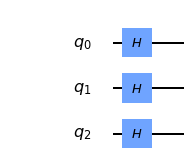

In [42]:
#Initialize the qGAN
#The qGAN consists of a quantum generator, a variational quantum circuit, and a classical discriminator,
#a neural network.
#To implement the quantum generator, we choose a depth-1 variational form that implements 
#R_Y rotations and CZ gates which takes a uniform distribution as an input state. 
#Notably, for k > 1 the generator's parameters must be chosen carefully. 
#For example, the circuit depth should be > 1 
#because higher circuit depths enable the representation of more complex structures.
#The classical discriminator is given by a 3-layer neural network that applies linear transformations, 
#leaky ReLU functions in the hidden layers and a sigmoid function in the output layer. 
#Notably, the neural network is implemented with PyTorch. 
#Please refer to https://pytorch.org/get-started/locally/ for PyTorch installation instructions.
#Here, both networks are updated with the ADAM optimization algorithm.

# Set number of training epochs - # of times training process should run
# Note: The algorithm's runtime can be shortened by reducing the number of training epochs.
num_epochs = 150
# Batch size
batch_size = 50

 # Initialize qGAN
qgan = QGAN(real_data, bounds, num_qubits, batch_size, num_epochs, snapshot_dir=None)
qgan.seed = 23
print(qgan)
# Set quantum instance to run the quantum generator
quantum_instance = QuantumInstance(backend=BasicAer.get_backend('statevector_simulator'))

#seed = 1059
#quantum_instance = QuantumInstance(backend, seed_simulator=seed, seed_transpiler=seed)

# Set entangler map
entangler_map = [[0, 1],[1,2]]  #Since we are using only two qubits

# Set an initial state for the generator circuit
init_state = UniformDistribution(sum(num_qubits), low=bounds[:,0], high=bounds[:,1])
q = QuantumRegister(sum(num_qubits), name='q')
qc = QuantumCircuit(q)
#Create a Quantum Circuit to represent the initial state
init_state.build(qc, q)
qc.draw(output='mpl')

In [43]:
#Create an Initial Distribution from the circuit
init_distribution = Custom(num_qubits=sum(num_qubits), circuit=qc)
#Setup the variational form
var_form = RY(int(np.sum(num_qubits)), depth=1, initial_state = init_distribution, 
              entangler_map=entangler_map, entanglement_gate='cz')
# Set generator's initial parameters
init_params = aqua_globals.random.rand(var_form._num_parameters) * 2 * np.pi
print(var_form._num_parameters)
#init_params = aqua_globals.random.rand(var_form._num_parameters) *  np.pi
# Set generator circuit
g_circuit = MultivariateVariationalDistribution(num_qubits, var_form, init_params,low=bounds[:,0], high=bounds[:,1])

6


In [44]:
num_qubits

[2, 1]

In [45]:
print(init_distribution)
print(var_form)
print(init_params)
print(g_circuit)

[3.25027846 5.94994152 4.80952551 1.77434542 1.38886898 4.31166052]


In [46]:
# Set quantum generator
qgan.set_generator(generator_circuit=g_circuit)
# Set classical discriminator neural network
discriminator = NumpyDiscriminator(len(num_qubits))
qgan.set_discriminator(discriminator)
print(qgan)

In [47]:
#Run the qGAN Training
#During the training the discriminator's and the generator's parameters are updated alternately w.r.t the following loss functions: $$ L_G\left(\phi, \theta\right) = -\frac{1}{m}\sum\limits_{l=1}^{m}\left[\log\left(D_{\phi}\left(g^{l}\right)\right)\right] $$ and $$ L_D\left(\phi, \theta\right) = \frac{1}{m}\sum\limits_{l=1}^{m}\left[\log D_{\phi}\left(x^{l}\right) + \log\left(1-D_{\phi}\left(g^{l}\right)\right)\right], $$ with $m$ denoting the batch size and $g^l$ describing the data samples generated by the quantum generator.

#Please note that the training will take a while ($\sim 20$ min).

# Run qGAN
qgan.run(quantum_instance)
# Runtime
end = time.time()
print('qGAN training runtime: ', (end - start)/60., ' min')

qGAN training runtime:  54.92404718399048  min


150


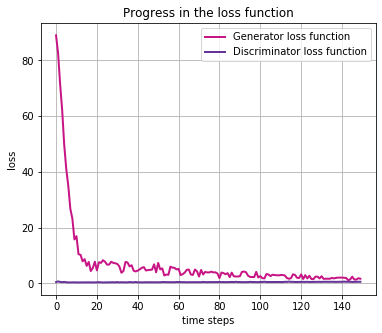

In [48]:
#Training Progress & Outcome
#Now, we plot the evolution of the generator's and the discriminator's loss functions 
#during the training as well as the progress in the relative entropy between the trained and the target distribution.
#Finally, we also compare the cumulative distribution function (CDF) of the trained distribution 
#to the CDF of the target distribution.

# Plot progress w.r.t the generator's and the discriminator's loss function

print(num_epochs)
t_steps = np.arange(num_epochs)
plt.figure(figsize=(6,5))
plt.title("Progress in the loss function")
plt.plot(t_steps, qgan.g_loss, label = "Generator loss function", color = 'mediumvioletred', linewidth = 2)
plt.plot(t_steps, qgan.d_loss, label = "Discriminator loss function", color = 'rebeccapurple', linewidth = 2)
plt.grid()
plt.legend(loc = 'best')
plt.xlabel('time steps')
plt.ylabel('loss')
plt.show()

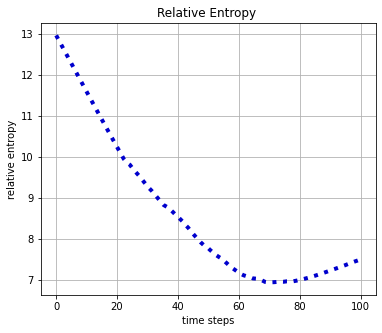

In [38]:
# Plot progress w.r.t relative entropy
plt.figure(figsize=(6,5))
plt.title("Relative Entropy ")
plt.plot(np.linspace(0, num_epochs, len(qgan.rel_entr)), qgan.rel_entr, color ='mediumblue', lw=4, ls=':')
plt.grid()
plt.xlabel('time steps')
plt.ylabel('relative entropy')
plt.show()

In [39]:
samples_g, prob_g = qgan.generator.get_output(qgan.quantum_instance, shots=10000)
samples_g,prob_g


([[0.0, 0.0],
  [0.0, 500.0],
  [33.333333333333336, 0.0],
  [33.333333333333336, 500.0],
  [66.66666666666667, 0.0],
  [66.66666666666667, 500.0],
  [100.0, 0.0],
  [100.0, 500.0]],
 [0.14855693743546203,
  0.2032283817157633,
  0.2961027601170625,
  0.004325211401370145,
  0.02957892133337306,
  0.2396030053888312,
  0.046900392844675,
  0.03170438976346363])

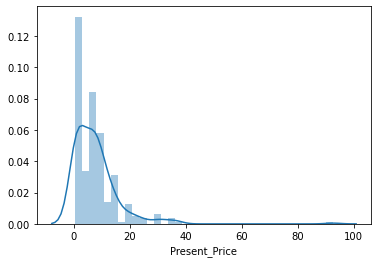

In [22]:
#samples_g = np.array(samples_g)
#samples_g = samples_g.flatten()
#num_bins = len(prob_g)
#plt.bar(samples_g[:,0],  prob_g, color='royalblue', width= 0.8, label='simulation')
#plt.bar(samples_g[:,1],  np.cumsum(prob_g), color='red', width= 0.8, label='simulation')
#plt.xticks(np.arange(min(samples_g[:,0]), max(samples_g[:,0])+1, 1.0))
#plt.grid()
#plt.xlabel('x')
#plt.ylabel('p(x)')
#plt.legend(loc='best')
#plt.show()

import seaborn as sn
sn.distplot(car_sale_selected['Present_Price'])


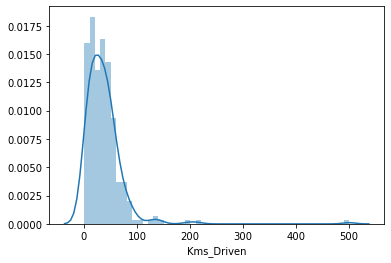

In [23]:
sn.distplot(car_sale_selected['Kms_Driven'])

In [115]:
prob_g

[0.014175630341460648,
 0.001646450978137167,
 0.00026077827447525874,
 0.003446247490580029,
 0.0583850268030057,
 0.010271850254472595,
 0.0016148201349084391,
 3.5811821845652405e-05,
 0.14361782801695708,
 0.016680719496815703,
 0.002642027795025544,
 0.03491503146483672,
 0.5915173107776953,
 0.1040673880263428,
 0.016360257344979784,
 0.00036282097846189226]